<a href="https://colab.research.google.com/github/DmitriyValetov/nlp_course_project/blob/master/ria_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RossiyaSegodnya Dataset for PyTorch
[github repository](https://github.com/RossiyaSegodnya/ria_news_dataset)

Full dataset 1003869 news 

https://github.com/RossiyaSegodnya/ria_news_dataset/raw/master/ria.json.gz

20 news 

https://raw.githubusercontent.com/RossiyaSegodnya/ria_news_dataset/master/ria_20.json

1000 news

https://raw.githubusercontent.com/RossiyaSegodnya/ria_news_dataset/master/ria_1k.json

normalized divided into sentences dataset (use second block)

https://drive.google.com/uc?id=1-UtATnzLE809Vi6RLgy3GRHX2TXRzhd6&export=download

# Download

## Raw

In [1]:
import requests
import os

# url = "https://raw.githubusercontent.com/RossiyaSegodnya/ria_news_dataset/master/ria_20.json"
url = "https://raw.githubusercontent.com/RossiyaSegodnya/ria_news_dataset/master/ria_1k.json"
# url = "https://github.com/RossiyaSegodnya/ria_news_dataset/raw/master/ria.json.gz"
fn, ext = os.path.splitext(os.path.basename(url))
print(f'downloading {fn + ext}')
r = requests.get(url) 
with open(fn + ext, 'wb') as f:
  f.write(r.content)
if ext == '.gz':  # requests should decompress .gz by default but don't...
  print(f'decompressing from {fn + ext} to {fn}')
  import gzip
  import shutil
  with gzip.open(fn + ext, 'rb') as gz_file:
    with open(fn, 'wb') as json_file:
      shutil.copyfileobj(gz_file, json_file)

downloading ria_1k.json


## Normalized and Tokenized

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1-UtATnzLE809Vi6RLgy3GRHX2TXRzhd6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.FetchMetadata()
fn = downloaded.metadata['title']
print(f'downloading: {fn}')
downloaded.GetContentFile(fn)

downloading: norm_sents_ria.json.gz


# Normalize and Tokenize
Skip this if you loaded a normalized dataset

In [2]:
import nltk
nltk.download('punkt')  # for sentence tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import json
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

# Files are not clear json files. They contain json strings line by line.
fn = fn + ext
norm_fn = f'norm_sents_{fn}'  # news divided into normalized sentences
with open(fn) as f:
  with open(norm_fn, 'a+') as nf:
    for line in tqdm(f, total=1003869):  # 1003869 - news at full dataset
      n = json.loads(line)
      text = BeautifulSoup(n['text']).get_text()
      title = BeautifulSoup(n['title']).get_text()
      text_ss = sent_tokenize(text)  # text sentences
      title_ss = sent_tokenize(title)  # title sentences
      norm_text_ss = [' '.join(w for w in word_tokenize(s) if w.isalnum()) for s in text_ss]
      norm_title_ss = [' '.join(w for w in word_tokenize(s) if w.isalnum()) for s in title_ss]
      json_str = json.dumps({'text': norm_text_ss, 'title': norm_title_ss}, ensure_ascii=False)
      nf.write(json_str + '\n')
with open(norm_fn) as nf: 
  print(json.loads(next(nf)))  # print first news


{'text': ['автор мария балябина на украине уволили уже больше 500 чиновников', 'это люстрация в деле', 'объявляя о начале второй волны очищения власти арсений яценюк заявлял что под действие закона подпадает около миллиона госслужащих', 'по прогнозам премьера на их увольнение потребуется два года', 'ну а пока закон претерпевает постоянные изменения', 'он больше не распространяется на ключевых представителей власти а в администрации президента планируют уточнить закон иначе придется уволить практически всех', 'киеву закон не писан', 'новые власти сами придумали правила очищения власти сами же их и меняют', 'закон о люстрации в его первоначальном варианте мог стоить политической карьеры многим нынешним чиновникам в том числе и тем кто отстаивал свержение старого руководства на майдане', 'например юлия тимошенко которая была при викторе януковиче по логике событий сейчас должна была бы оставить свой пост', 'это же относится и ко всему ее окружению', 'и к петру порошенко кстати тоже', 'ту

In [5]:
import gzip
import shutil

comp_fn = norm_fn + '.gz'
# compress normalized dataset
print(f'compressing {norm_fn} to {comp_fn}')
with gzip.open(comp_fn, 'wb') as gz_file:
  with open(norm_fn, 'rb') as json_file:
    shutil.copyfileobj(json_file, gz_file)

# check
with gzip.open(comp_fn, 'rb') as gz_file:
  print(json.loads(next(gz_file)))

compressing norm_sents_ria_1k.json to norm_sents_ria_1k.json.gz
{'text': ['автор мария балябина на украине уволили уже больше 500 чиновников', 'это люстрация в деле', 'объявляя о начале второй волны очищения власти арсений яценюк заявлял что под действие закона подпадает около миллиона госслужащих', 'по прогнозам премьера на их увольнение потребуется два года', 'ну а пока закон претерпевает постоянные изменения', 'он больше не распространяется на ключевых представителей власти а в администрации президента планируют уточнить закон иначе придется уволить практически всех', 'киеву закон не писан', 'новые власти сами придумали правила очищения власти сами же их и меняют', 'закон о люстрации в его первоначальном варианте мог стоить политической карьеры многим нынешним чиновникам в том числе и тем кто отстаивал свержение старого руководства на майдане', 'например юлия тимошенко которая была при викторе януковиче по логике событий сейчас должна была бы оставить свой пост', 'это же относится и

# Process

In [0]:
import gzip
import json

comp_fn = 'norm_sents_ria.json.gz'

# check
with gzip.open(comp_fn, 'rb') as gz_file:
  print(json.loads(next(gz_file)))

{'text': ['москва 31 янв риа новости', 'большая часть из 33 детей которых граждане сша пытались вывезти из гаити в организованный в доминиканской республике приют не являются сиротами сообщает в воскресенье агентство франс пресс со ссылкой на заявление представителя международной организации детские деревни sos sos children village оказывающей помощь детям оставшимся без родителей как заявила агентству патрисия варгас patricia vargas курирующая программы детских деревень sos в центральной америке мексике и на карибах поговорив с детьми она выяснила что родители многих из них живы', 'некоторые дети смогли назвать свои домашние адреса и номера телефонов что дает возможность связаться с их родителями', 'в это воскресенье гаитянская полиция задержала десятерых граждан сша подозреваемых в попытке без разрешения вывезти более 30 детей в доминиканскую республику', 'представитель баптистской церкви в городе меридиан американского штата айдахо шон лэнкфорд sean lankford заявил что задержанные п

In [6]:
from tqdm.notebook import tqdm

news = []
n_news = 1000
with gzip.open(comp_fn, 'rb') as gz_file:
  for _ in tqdm(range(n_news)):
    news.append(json.loads(next(gz_file)))
print(news[0])
print(len(news))


{'text': ['автор мария балябина на украине уволили уже больше 500 чиновников', 'это люстрация в деле', 'объявляя о начале второй волны очищения власти арсений яценюк заявлял что под действие закона подпадает около миллиона госслужащих', 'по прогнозам премьера на их увольнение потребуется два года', 'ну а пока закон претерпевает постоянные изменения', 'он больше не распространяется на ключевых представителей власти а в администрации президента планируют уточнить закон иначе придется уволить практически всех', 'киеву закон не писан', 'новые власти сами придумали правила очищения власти сами же их и меняют', 'закон о люстрации в его первоначальном варианте мог стоить политической карьеры многим нынешним чиновникам в том числе и тем кто отстаивал свержение старого руководства на майдане', 'например юлия тимошенко которая была при викторе януковиче по логике событий сейчас должна была бы оставить свой пост', 'это же относится и ко всему ее окружению', 'и к петру порошенко кстати тоже', 'ту

![pos](https://pythonspot.com/wp-content/uploads/2016/08/nltk-speech-codes.png)

In [288]:
from collections import Counter

words = Counter()
for n in news:
  words.update(w for s in n['text'] for w in s.split())
  words.update(w for s in n['title'] for w in s.split())
print(words.most_common(10))
print(len(words))

[('в', 12616), ('и', 6737), ('на', 5541), ('по', 3045), ('с', 2945), ('что', 2790), ('не', 2134), ('за', 1225), ('о', 1138), ('новости', 1098)]
37996


In [291]:
from torchtext.vocab import Vocab, SubwordVocab
min_freq = 0
max_size = 40000
voc = Vocab(counter=words, max_size=max_size, specials=['<pad>', '<unk>', '<go>', '<eos>'])
# voc = SubwordVocab(counter=words, max_size=max_size, specials=['<pad>', '<unk>', '<go>', '<eos>'])
print(len(voc))
print(dir(voc))
print(voc.stoi)

38000
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'extend', 'freqs', 'itos', 'load_vectors', 'set_vectors', 'stoi', 'vectors']
defaultdict(<function _default_unk_index at 0x7fbd1d6edd08>, {'<pad>': 0, '<unk>': 1, '<go>': 2, '<eos>': 3, 'в': 4, 'и': 5, 'на': 6, 'по': 7, 'с': 8, 'что': 9, 'не': 10, 'за': 11, 'о': 12, 'новости': 13, 'риа': 14, 'для': 15, 'к': 16, 'из': 17, 'года': 18, '1': 19, 'дек': 20, 'россии': 21, 'как': 22, 'до': 23, 'а': 24, 'от': 25, 'украины': 26, 'рф': 27, 'это': 28, 'он': 29, 'заявил': 30, 'также': 31, 'москва': 32, 'будет': 33, 'декабря': 34, 'его': 35, 'году': 36, 'во': 37, 'но': 38, 'при': 39, 'у': 40, 'мы': 41, 'после': 42, 'понедельник': 43, 'более': 

In [293]:
from torch.utils.data import Dataset, IterableDataset, DataLoader, random_split
import json

class RiaDataset(IterableDataset):
  def __init__(self, path, start, end, vocab):
    super(RiaDataset).__init__()
    self.path = path
    self.start = start
    self.end = end
    self.vocab = vocab

  def __len__(self):
    return self.end - self.start

  def __iter__(self):
    worker_info = torch.utils.data.get_worker_info()
    # print(worker_info.id, id(self), self.start, self.end)
    with open(self.path) as f:
      for _ in range(self.start):
        next(f)
      for _ in range(self.start, self.end):
        yield self.preprocess(next(f))

  def preprocess(self, data):
    data = json.loads(data)
    enc_text = [[self.vocab.stoi.get(w, 1) for w in s.split()] for s in data['text']]
    enc_title = [[self.vocab.stoi.get(w, 1) for w in s.split()] for s in data['title']]
    # dec_text = [[self.vocab.itos[w] for w in s] for s in enc_text]
    # enc_text = [[w for w in s.split()] for s in data['text']]
    # enc_text = [w for s in data['text'] for w in s.split()]
    # enc_title = [w for s in data['title'] for w in s.split()]
    enc_title = [self.vocab.stoi.get(w, 1) for s in data['title'] for w in s.split()]
    enc_text = [self.vocab.stoi.get(w, 1) for s in data['text'] for w in s.split()][:len(enc_title)*3]
    return [enc_text, enc_title]

def worker_init_fn(worker_id):
  worker_info = torch.utils.data.get_worker_info()
  s, e = worker_info.dataset.start, worker_info.dataset.end
  n = worker_info.num_workers
  q, r = (e - s) // n, (e - s) % n
  s = s + worker_id * q
  e = s + q if worker_id < n - 1 else s + q + r
  worker_info.dataset.start, worker_info.dataset.end = s, e

def collate_fn(batch):
  bx1, bx2 = [], []
  for b in batch:
    bx1.append(torch.tensor(b[0]))
    bx2.append(torch.tensor(b[1]))
  bx1 = torch.nn.utils.rnn.pad_sequence(bx1, batch_first=True)
  bx2 = torch.nn.utils.rnn.pad_sequence(bx2, batch_first=True)
  batch = [bx1, bx2]
  return batch

ds = RiaDataset('norm_sents_ria_1k.json', 0, 100, voc)
dl = DataLoader(ds, batch_size=3, num_workers=1, shuffle=False, drop_last=False, 
                                 collate_fn=collate_fn, worker_init_fn=worker_init_fn)
for b in tqdm(dl):
  print(b[0].size(), b[1].size())
  print(len(b))
# train_len = int(0.7*len(ds))
# test_len = int(0.2*len(ds))
# val_len = len(ds) - train_len - test_len
# lens = [train_len, test_len, val_len]
# print(lens)
# train_ds, test_ds, val_ds = random_split(ds, lens)
# dl = DataLoader(train_ds, batch_size=2, num_workers=1, shuffle=False, drop_last=False, 
#                                  collate_fn=collate_fn, worker_init_fn=worker_init_fn)
# # print(dir(train_ds))
# # print(train_ds.indices)
# for b in tqdm(dl):
#   print(b[0].size(), b[1].size())
#   print(len(b))

torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 36]) torch.Size([3, 12])
2
torch.Size([3, 36]) torch.Size([3, 12])
2
torch.Size([3, 27]) torch.Size([3, 9])
2
torch.Size([3, 39]) torch.Size([3, 13])
2
torch.Size([3, 36]) torch.Size([3, 12])
2
torch.Size([3, 33]) torch.Size([3, 11])
2
torch.Size([3, 27]) torch.Size([3, 9])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 27]) torch.Size([3, 9])
2
torch.Size([3, 24]) torch.Size([3, 8])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 27]) torch.Size([3, 9])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 33]) torch.Size([3, 11])
2
torch.Size([3, 30]) torch.Size([3, 10])
2
torch.Size([3, 36]) torch.Size([3, 12])
2
torch.Size([3, 33]) torch.Size([3, 11])
2
torch.Size([3, 33]) torch.Size([3, 11])
2
torch.Size([3, 36]) torch.Size([3, 12])
2
torch.Size([3, 27]) torch.Size([3, 9])
2
torch.Size([3, 33]) torch.Size([3, 11])


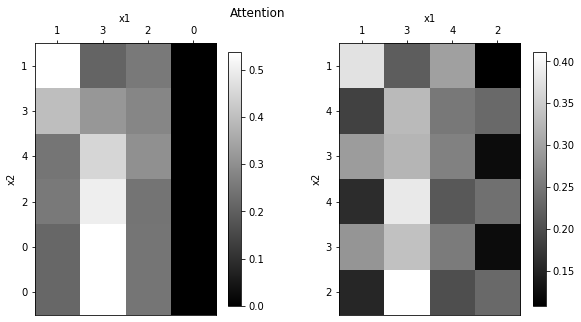

In [266]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, padding_idx,
               rnn_type, hidden_size, num_layers=1, rnn_dropout=0,
               bidirectional=False, dropout=0, pack=False):
    super(EncoderRNN, self).__init__()
    rnn_map = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                  embedding_dim=embedding_dim,
                                  padding_idx=padding_idx)
    self.rnn = rnn_map[rnn_type](input_size=embedding_dim, 
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 dropout=rnn_dropout,
                                 bidirectional=bidirectional)
    self.dropout = nn.Dropout(dropout)
    self.pack = pack

  def forward(self, x1):  # [B, L]
    x = self.embedding(x1)  # [B, L] -> [B, L, E]
    if self.pack:  # [B, L, E] -> Packed [B, L, E]
      ls = torch.sum(x1 != 0, dim=1)
      x = pack_padded_sequence(x, ls, batch_first=True, enforce_sorted=False)
    # [B, L, E] -> (Packed) [B, L, ND*H], ([NL*ND, B, H], ([NL*ND, B, H]))
    if isinstance(self.rnn, nn.LSTM):
      ht, (hn, cn) = self.rnn(x)
      hn, cn = self.dropout(hn), self.dropout(cn)
      return ht, (hn, cn)
    else:
      ht, hn = self.rnn(x)
      hn = self.dropout(hn)
      return ht, hn


class AttentionDecoderRNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, padding_idx,
               rnn_type, hidden_size, num_layers=1, rnn_dropout=0,
               bidirectional=False, dropout=0, out_hidden=0,
               attn_type='soft_dot', pack=False):
    super(AttentionDecoderRNN, self).__init__()
    rnn_map = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}
    attn_types = ['dot', 'cos', 'dist', 'soft_dot', 'soft_cos', 'soft_dist', 'none']
    self.attn_type = attn_type
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                  embedding_dim=embedding_dim,
                                  padding_idx=padding_idx)
    self.rnn = rnn_map[rnn_type](input_size=embedding_dim, 
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 dropout=rnn_dropout,
                                 bidirectional=bidirectional)
    out_input = hidden_size if self.attn_type == 'none' else 2*hidden_size
    if out_hidden > 0:
      self.out_hidden = nn.Linear(out_input, out_hidden)
      self.out = nn.Linear(out_hidden, num_embeddings)
    else:
      self.out_hidden = None
      self.out = nn.Linear(out_input, num_embeddings)
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.LogSoftmax(dim=2)
    self.pack = pack

  def forward(self, x2, h1, x1):  # [B, L], [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    x = self.embedding(x2)  # [B, L] -> [B, L, E]
    if self.pack:  # [B, L, E] -> Packed [B, L, E]
      lengths = torch.sum(x2 != 0, dim=1)
      x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    ht1, hns1 = h1  # [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    # [B, L, D], ([NL*ND, B, H], [NL*ND, B, H]) -> [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    ht2, hns2 = self.rnn(x, hns1)
    if self.pack:  # Packed [B, L, E] -> [B, L, E]
      ht1, _ = pad_packed_sequence(ht1, batch_first=True)
      ht2, _ = pad_packed_sequence(ht2, batch_first=True)
    if self.attn_type == 'none':
      if self.rnn.bidirectional:
        B2, L2, NDH2 = ht2.size()
        # [B, L, ND*H] -> [B, L, ND, H] -> [B, L, H]
        ht2 = ht2.view(B2, L2, 2, int(NDH2/2)).mean(2)
      x = self.dropout(ht2)
      if self.out_hidden is not None:
        x = self.out_hidden(x)
      x = self.out(x)
      y2 = self.softmax(x)
      return y2, None
    else:
      if self.rnn.bidirectional:
        B1, L1, NDH1 = ht1.size()
        B2, L2, NDH2 = ht2.size()  # B1 == B2, NDH1 == NDH2
        # [B, L, ND*H] -> [B, L, ND, H] -> [B, L, H]
        ht1 = ht1.view(B1, L1, 2, int(NDH1/2)).mean(2)
        ht2 = ht2.view(B2, L2, 2, int(NDH2/2)).mean(2)
      # [L2, H], [L1, H] -> [L2, L1]
      # mask where x1 and x2 token is <PAD>
      # pad_mask = torch.einsum('bi,bj->bij', x2, x1) == 0
      # mask where only x1 token is <PAD>
      pad_mask = torch.einsum('bi,bj->bij', torch.ones_like(x2), x1) == 0
      # [B, L2, H], [B, L1, H] -> [B, L2, L1]  # attention
      # [B, L2, L1], [B, L1, H] -> [B, L2, H]  # weighted h1
      if self.attn_type == 'dot':
        attn = torch.einsum('bih,bjh->bij', ht2, ht1)  # dot product
        attn[pad_mask] = 0
      elif self.attn_type == 'soft_dot':
        attn = torch.einsum('bih,bjh->bij', ht2, ht1)  # dot product
        attn[pad_mask] = float('-inf')
        attn = F.softmax(attn, 2)
      elif self.attn_type == 'dist':
        ht1, ht2 = ht1.contiguous(), ht2.contiguous()
        attn = torch.cdist(ht2, ht1)  # euclidian distance
        attn = torch.masked_fill(attn, pad_mask, float('inf'))
        attn = F.threshold(attn, threshold=1e-6, value=1e-6)  # short dist
        attn = 1/attn  # inverse
        attn = F.normalize(attn, p=1, dim=2)  # to [0, 1]
      elif self.attn_type == 'soft_dist':
        ht1, ht2 = ht1.contiguous(), ht2.contiguous()
        attn = torch.cdist(ht2, ht1)  # euclidian distance
        attn = torch.masked_fill(attn, pad_mask, float('inf'))
        attn = F.softmin(attn, 2)
      elif self.attn_type == 'cos':
        ht1n = F.normalize(ht1, p=2, dim=2)  # normalize to length = 1
        ht2n = F.normalize(ht2, p=2, dim=2)  # normalize to length = 1
        attn = torch.einsum('bih,bjh->bij', ht2n, ht1n)  # dot product
        attn[pad_mask] = 0
      elif self.attn_type == 'soft_cos':
        ht1n = F.normalize(ht1, p=2, dim=2)  # normalize to length = 1
        ht2n = F.normalize(ht2, p=2, dim=2)  # normalize to length = 1
        attn = torch.einsum('bih,bjh->bij', ht2n, ht1n)  # dot product
        attn[pad_mask] = float('-inf')
        attn = F.softmax(attn, 2)
      hw1 = torch.einsum('bij,bjh->bih', attn, ht1)  # weighted h1
      ha = torch.cat((ht2, hw1), 2)  # [B, L2, H], [B, L2, H] -> [B, L2, H+H]
      x = self.dropout(ha)  # [B, L2, H+H] -> [B, L2, H+H]
      if self.out_hidden is not None:
        x = self.out_hidden(x)   # [B, L2, H+H] -> [B, L2, OH]
      x = self.out(x)  # [B, L2, H+H] or [B, L2, OH] -> [B, L2, D2]
      y2 = self.softmax(x)  # [B, L2, D2] -> [B, L2, D2]
      return y2, attn


class EncoderDecoder(nn.Module):
  def __init__(self, 
               enc_num_embeddings, enc_embedding_dim, enc_padding_idx,
               dec_num_embeddings, dec_embedding_dim, dec_padding_idx,
               rnn_type, hidden_size, num_layers=1, out_hidden=0,
               enc_rnn_dropout=0, dec_rnn_dropout=0,
               bidirectional=False, enc_dropout=0, dec_dropout=0, 
               attn_type='dot', pack=False):
    super(EncoderDecoder, self).__init__()
    self.encoder = EncoderRNN(num_embeddings=enc_num_embeddings, 
                              embedding_dim=enc_embedding_dim, 
                              padding_idx=enc_padding_idx,
                              hidden_size=hidden_size, 
                              rnn_type=rnn_type, 
                              bidirectional=bidirectional,
                              num_layers=num_layers,
                              dropout=enc_dropout,
                              rnn_dropout=enc_rnn_dropout,
                              pack=pack)
    self.decoder = AttentionDecoderRNN(num_embeddings=dec_num_embeddings, 
                                       embedding_dim=dec_embedding_dim, 
                                       padding_idx=dec_padding_idx,
                                       hidden_size=hidden_size, 
                                       rnn_type=rnn_type, 
                                       bidirectional=bidirectional,
                                       num_layers=num_layers,
                                       dropout=dec_dropout,
                                       out_hidden=out_hidden,
                                       rnn_dropout=dec_rnn_dropout,
                                       attn_type=attn_type,
                                       pack=pack)

  def forward(self, x1, x2):
    #  [B, L1] -> [B, L1, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    h1 = self.encoder(x1)
    # [B, L2], ([B, L1, ND*H], ([NL*ND, B, H], [NL*ND, B, H])) -> [B, L2, E2]
    y2 = self.decoder(x2, h1, x1)
    return y2


def external_attn(x1, x2, attn_dict):
    attn_dict = {1: [1], 2: [2], 4: [4, 3]}
    attn = []
    B1, L1 = x1.size()
    B2, L2 = x2.size()
    for i in range(B1):
      b = []
      for j in range(L2):
        l2 = []
        # x2t = x2[i, j].item()
        x2t = x2[i, j + 1].item() if j + 2 < L2 else 0 # decoder shift
        for k in range(L1):
          x1t = x1[i, k].item()
          # x1t = x1[i, k + 1].item() if k + 1 < L1 else 0 # encoder shift
          x1ts = self.attn_dict.get(x2t, [])
          if x1t in x1ts:
            l2.append(1.)
          else:
            l2.append(0.)
        b.append(l2)
      attn.append(b)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    attn = torch.tensor(attn).to(device)
    attn = F.normalize(attn, p=1, dim=2)  # to [0, 1]
    return attn


from IPython.display import Image
# Image(make_dot(loss).render('loss', format='png'))
from tqdm.notebook import tqdm
from torch import optim
import numpy as np

def plot_attention(a, x1, x2, shift=True, mask=True, 
                   suptitle='Attention', figsize=None, 
                   decoder_x1=None, decoder_x2=None, tight=False,
                   labels=True):
  # %matplotlib inline
  import matplotlib.pyplot as plt
  from mpl_toolkits.axes_grid1 import make_axes_locatable

  b = a.shape[0]
  fig, axs = plt.subplots(1, b, figsize=figsize)
  if not isinstance(axs, np.ndarray):  # if batch size == 1
    axs = [axs]
  fig.suptitle(suptitle)
  for i in range(b):
    ax = axs[i]
    if shift:
      ba, bx1, bx2 = a[i,:-1,1:], x1[i,1:], x2[i,1:]
    else:
      ba, bx1, bx2 = a[i], x1[i], x2[i]
    if mask:
      mask_x1 = np.flatnonzero(bx1)
      mask_x2 = np.flatnonzero(bx2)
      ba, bx1, bx2 =  ba[mask_x2,:][:,mask_x1], bx1[mask_x1], bx2[mask_x2]
    # ax.set_title(f'{i+1}', y=-0.2)
    im = ax.imshow(ba, cmap='gray')
    ax.set_xticks(np.arange(len(bx1)))
    ax.set_yticks(np.arange(len(bx2)))
    if labels:
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    if decoder_x1 is not None:
      bx1 = decoder_x1(bx1)
    if decoder_x2 is not None:
      bx2 = decoder_x2(bx2)
    ax.set_xticklabels(bx1)  # rotation=90
    ax.set_yticklabels(bx2)
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05)
  if tight:
    plt.tight_layout()

# torch.backends.cudnn.enabled=False
# torch.backends.cudnn.deterministic=True
# torch.autograd.set_detect_anomaly(True)

enc_dec_config = {
  'enc_num_embeddings': 5,
  'enc_embedding_dim': 2,
  'enc_padding_idx': 0,
  'dec_num_embeddings': 5,
  'dec_embedding_dim': 2,
  'dec_padding_idx': 0,
  'rnn_type': 'RNN',
  'hidden_size': 2,
  'num_layers': 1,
  'bidirectional': False,
  'enc_rnn_dropout': 0,
  'dec_rnn_dropout': 0,
  'enc_dropout': 0,
  'dec_dropout': 0,
  'attn_type': 'soft_dist',
  'out_hidden': 16,
  'pack': True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = EncoderDecoder(**enc_dec_config).to(device)
x1 = torch.tensor([[1, 3, 2, 0], [1, 3, 4, 2]]).to(device)
x2 = torch.tensor([[1, 3, 4, 2, 0, 0], [1, 4, 3, 4, 3, 2]]).to(device)
opt = optim.Rprop(model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss(ignore_index=0)  # 0 is <PAD>
pbar = tqdm(range(200))
for i in pbar:
  opt.zero_grad()
  t = x2[:,1:].flatten(0)
  y2, attn = model(x1, x2)
  p = y2[:,:-1,:].flatten(0, 1)
  loss = loss_fn(p, t)
  loss.backward()
  opt.step()
  with torch.no_grad():
    idx = torch.nonzero(t).view(-1)
    acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
    if i % 25 == 0:
      # print(attn)
      # print(p)
      # print(torch.argmax(p, 1))
      # print(t)
      if attn is not None:
         plot_attention(attn.detach().cpu().numpy(), 
                        x1.detach().cpu().numpy(), 
                        x2.detach().cpu().numpy(),
                        labels=True, tight=False,
                        shift=False, mask=False, figsize=(10, 5))
  pbar.set_description(f'loss: {loss:.3f}, acc: {acc:.3f}')
  if acc == 1:
    break
# Image(make_dot(attn).render('attn', format='png'))

In [255]:
!pip install optuna

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 9.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 112kB 24.2MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=ff565506c28524d2378358936828198058ffcca13e17922a2824f068f3c5e4ae
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.4.0-cp36-none-any.whl size=254554 sha256=65a34c2e75e9e5a9b97b12487c978377cd5651eb3c8b956e653a53643188dbaa
  Stored in directory: /root/.cache/pip/wheels/3e/48

In [287]:
import torch
import optuna
from tqdm.notebook import tqdm
from pprint import pprint
import random
import numpy as np

def objective(trial):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  trial.set_user_attr('device', str(device))
  opt_fn_map = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'Adagrad': optim.Adagrad,
    'ASGD': optim.ASGD,
    'Adamax': optim.Adamax,
    'SparseAdam': optim.SparseAdam,
    'AdamW': optim.AdamW,
    'Adadelta': optim.Adadelta,
    'LBFGS': optim.LBFGS,
    'RMSprop': optim.RMSprop,
    'Rprop': optim.Rprop
  }
  train_config = {
    'seed': trial.suggest_int('seed', 0, 0),
    'n_epoches': trial.suggest_int('n_epoches', 10, 10),
    'lr': trial.suggest_loguniform('lr', 1e-3, 1e-3),
    # 'opt_fn': trial.suggest_categorical('opt_fn', ['SGD', 'Adam', 'Adagrad', 
    #                                           'ASGD', 'Adamax',
    #                                           'AdamW', 'Adadelta',
    #                                           'RMSprop', 'Rprop']),
    'opt_fn': trial.suggest_categorical('opt_fn', ['Adam']),
    'batch_size': trial.suggest_int('batch_size', 5, 5),
    'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-6)
  }
  model_config = {
    'enc_num_embeddings': len(voc),
    'enc_embedding_dim': trial.suggest_int('enc_embedding_dim', 300, 300),
    'enc_padding_idx': 0,
    'dec_num_embeddings': len(voc),
    'dec_embedding_dim': trial.suggest_int('dec_embedding_dim', 300, 300),
    'dec_padding_idx': 0,
    'rnn_type': trial.suggest_categorical('rnn_type', ['RNN']),
    # 'rnn_type': trial.suggest_categorical('rnn_type', ['RNN']),
    'hidden_size': trial.suggest_int('hidden_size', 300, 300),
    'num_layers': trial.suggest_int('num_layers', 1, 1),
    'bidirectional': trial.suggest_categorical('bidirectional', [False]),
    # 'bidirectional': trial.suggest_categorical('bidirectional', [True]),
    'enc_dropout': trial.suggest_uniform('enc_dropout', 0.0, 0.0),
    'dec_dropout': trial.suggest_uniform('dec_dropout', 0.0, 0.0),
    'enc_rnn_dropout': trial.suggest_uniform('enc_rnn_dropout', 0.0, 0.0),
    'dec_rnn_dropout': trial.suggest_uniform('dec_rnn_dropout', 0.0, 0.0),
    'attn_type': trial.suggest_categorical('attn_type', ['soft_dist']),
    # 'attn_type': trial.suggest_categorical('attn_type', ['dot', 'dist', 'soft_dot', 'soft_dist', 'cos', 'soft_cos', 'none']),
    'out_hidden': trial.suggest_int('out_hidden', 600, 600),
    'pack': trial.suggest_categorical('pack', [True]),
  }
  # train
  seed = train_config['seed']
  opt_fn = train_config['opt_fn']
  lr = train_config['lr']
  n_epoches = train_config['n_epoches']
  batch_size = train_config['batch_size']
  weight_decay = train_config['weight_decay']
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  model = EncoderDecoder(**model_config).to(device)
  if opt_fn not in ['Rprop']:
    opt = opt_fn_map[opt_fn](model.parameters(), lr=lr, 
                             weight_decay=weight_decay)
  else:
    opt = opt_fn_map[opt_fn](model.parameters(), lr=lr)
  loss_fn = torch.nn.NLLLoss(ignore_index=0)
  path = 'norm_sents_ria_1k.json'
  train_ds = RiaDataset(path, 0, 70, voc)
  test_ds = RiaDataset(path, 70, 90, voc)
  val_ds = RiaDataset(path, 90, 100, voc)
  # train_ds, test_ds, val_ds = random_split(ds, lens)
  # train_dl, test_dl, val_dl = train_test_val_split(eng_rus, 
  #                                                  batch_size=batch_size)
  train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=1, 
                        shuffle=False, drop_last=False,
                        collate_fn=collate_fn, worker_init_fn=worker_init_fn)
  test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1, 
                        shuffle=False, drop_last=False,
                        collate_fn=collate_fn, worker_init_fn=worker_init_fn)
  val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=1, 
                      shuffle=False, drop_last=False,
                      collate_fn=collate_fn, worker_init_fn=worker_init_fn)
  pprint(trial.params)
  pbar_epoch = tqdm(range(n_epoches))
  for i in tqdm(pbar_epoch):
    # train
    model.train()
    pbar_train = tqdm(train_dl)
    accs = []
    for x1, x2 in pbar_train:
      opt.zero_grad()
      x1.to(device)
      x2.to(device)
      t = x2[:,1:].flatten(0)
      y2, attn = model(x1, x2)
      p = y2[:,:-1,:].flatten(0, 1)
      loss = loss_fn(p, t)
      loss.backward()
      opt.step()
      with torch.no_grad():
        idx = torch.nonzero(t).view(-1)
        acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
        accs.append(acc)
      pbar_train.set_description(f'epoch: {i+1}, loss: {loss:.3f}, acc: {acc:.3f}')
    # y2d = map(eng_rus.decode_x2, torch.argmax(y2[:,:-1,:], 2).cpu().numpy())
    # x2d = map(eng_rus.decode_x2, x2[:,1:].cpu().numpy())
    # x1d = map(eng_rus.decode_x1, x1[:,1:].cpu().numpy())
    # triples = list(zip(x1d, x2d, y2d))
    # pprint(triples)
    # validation
    model.eval()
    val_accs = []
    with torch.no_grad():
      pbar_val = tqdm(val_dl)
      for x1, x2 in pbar_val:
        x1.to(device)
        x2.to(device)
        t = x2[:,1:].flatten(0)
        y2, attn = model(x1, x2)
        p = y2[:,:-1,:].flatten(0, 1)
        val_loss = loss_fn(p, t)
        idx = torch.nonzero(t).view(-1)
        val_acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
        val_accs.append(val_acc)
      pbar_val.set_description(f'epoch: {i+1}, val_loss: {val_loss:.3f}, val_acc: {val_acc:.3f}')
    m_acc = sum(accs)/len(accs)
    m_val_acc = sum(val_accs)/len(val_accs)
    pbar_epoch.set_description(f'loss: {loss:.3f}, acc: {m_acc:.3f} vloss: {val_loss:.3f}, vacc: {m_val_acc:.3f}')
    trial.report(loss, step=i+1)
    torch.save({'epoch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'model_config': model_config,
                'train_config': train_config},
                'model.pth')
    # try:
    #   uploaded = drive.CreateFile({'title': 'model.pth'})
    #   uploaded.SetContentFile('model.pth')
    #   uploaded.Upload()
    # except Exception as e:
    #   print(e)
  # test
  model.eval()
  test_accs = []
  with torch.no_grad():
    pbar_test = tqdm(test_dl)
    for x1, x2 in pbar_test:
      x1.to(device)
      x2.to(device)
      t = x2[:,1:].flatten(0)
      y2, attn = model(x1, x2)
      p = y2[:,:-1,:].flatten(0, 1)
      test_loss = loss_fn(p, t)
      idx = torch.nonzero(t).view(-1)
      test_acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
      test_accs.append(test_acc)
    pbar_val.set_description(f'epoch: {i+1}, test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')
  m_test_acc = sum(test_accs)/len(test_accs)
  print(f'mean test_acc: {m_test_acc}')
  # if model_config['attn_type'] != 'none':
  #   plot_attention(attn.clone().cpu().numpy()[:1], 
  #                   x1.clone().cpu().numpy()[:1], 
  #                   x2.clone().cpu().numpy()[:1],
  #                   decoder_x1 = eng_rus.decode_x1,
  #                   decoder_x2 = eng_rus.decode_x2,
  #                   figsize=(10, 10),
  #                   shift=True,
  #                   mask=True,
  #                   suptitle=model_config['attn_type'])
  trial.set_user_attr('train_loss', loss.item())
  trial.set_user_attr('val_loss', val_loss.item())
  trial.set_user_attr('test_loss', test_loss.item())
  trial.set_user_attr('train_acc', m_acc.item())
  trial.set_user_attr('val_acc', m_val_acc.item())
  trial.set_user_attr('test_acc', m_test_acc.item())
  # y2d = map(eng_rus.decode_x2, torch.argmax(y2[:,:-1,:], 2).cpu().numpy())
  # x2d = map(eng_rus.decode_x2, x2[:,1:].cpu().numpy())
  # x1d = map(eng_rus.decode_x1, x1[:,1:].cpu().numpy())
  # triples = list(zip(x1d, x2d, y2d))[:1]
  # pprint(triples)
  return loss

fn = 'optuna.db'
study = optuna.create_study(study_name='1', 
                            direction='minimize', 
                            storage=f'sqlite:///{fn}', 
                            load_if_exists=True)
study.optimize(objective, n_trials=1)
# try:
#   uploaded = drive.CreateFile({'title': fn})
#   uploaded.SetContentFile(fn)
#   uploaded.Upload()
# except Exception as e:
#   print(e)

[I 2020-05-12 21:38:35,482] Using an existing study with name '1' instead of creating a new one.


{'attn_type': 'soft_dist',
 'batch_size': 5,
 'bidirectional': False,
 'dec_dropout': 0.0,
 'dec_embedding_dim': 300,
 'dec_rnn_dropout': 0.0,
 'enc_dropout': 0.0,
 'enc_embedding_dim': 300,
 'enc_rnn_dropout': 0.0,
 'hidden_size': 300,
 'lr': 0.001,
 'n_epoches': 10,
 'num_layers': 1,
 'opt_fn': 'Adam',
 'out_hidden': 600,
 'pack': True,
 'rnn_type': 'RNN',
 'seed': 0,
 'weight_decay': 1e-06}



mean test_acc: 0.6046258807182312


[I 2020-05-12 21:38:47,039] Finished trial#7 with value: 0.6803472638130188 with parameters: {'attn_type': 'soft_dist', 'batch_size': 5, 'bidirectional': False, 'dec_dropout': 0.0, 'dec_embedding_dim': 300, 'dec_rnn_dropout': 0.0, 'enc_dropout': 0.0, 'enc_embedding_dim': 300, 'enc_rnn_dropout': 0.0, 'hidden_size': 300, 'lr': 0.001, 'n_epoches': 10, 'num_layers': 1, 'opt_fn': 'Adam', 'out_hidden': 600, 'pack': True, 'rnn_type': 'RNN', 'seed': 0, 'weight_decay': 1e-06}. Best is trial#6 with value: 0.6803472638130188.


In [0]:
!pip install revtok

In [0]:
from torchtext.vocab import Vocab, SubwordVocab
min_freq = 10
max_size = 200
# voc = Vocab(counter=words, max_size=max_size, specials=['<pad>', '<unk>', '<go>', '<eos>'])
voc = SubwordVocab(counter=words, max_size=max_size, specials=['<pad>', '<unk>', '<go>', '<eos>'])
print(len(voc))

building subword vocab:   0%|          | 0/137 [00:00<?, ?it/s]

For faster subwords, please install Julia 0.6, pyjulia, and Revtok.jl. Falling back to Python implementation...


building subword vocab: 100%|██████████| 137/137 [00:00<00:00, 147.34it/s]

204


In [0]:
print(voc.stoi)
toks = voc.segment(['hello', 'world'])
toks = voc.segment('hello world')
print(toks)
idxs = [voc.stoi[x] for x in toks]
print(idxs)
[voc.itos[x] for x in idxs]



defaultdict(<function _default_unk_index at 0x7f8949017b70>, {'<pad>': 0, '<unk>': 1, '<go>': 2, '<eos>': 3, 'о': 4, 'е': 5, 'а': 6, 'и': 7, 'т': 8, 'н': 9, 'р': 10, 'с': 11, 'в': 12, 'л': 13, 'м': 14, 'д': 15, 'к': 16, 'п': 17, 'у': 18, 'ы': 19, 'г': 20, 'я': 21, 'б': 22, 'з': 23, 'ь': 24, 'й': 25, 'ч': 26, 'х': 27, 'ю': 28, 'ж': 29, 'ц': 30, 'ш': 31, 'щ': 32, 'ф': 33, 'э': 34, '1': 35, '0': 36, '2': 37, '3': 38, '4': 39, 'a': 40, 'r': 41, 'e': 42, 's': 43, '6': 44, '9': 45, 'i': 46, '5': 47, 'n': 48, 'o': 49, '7': 50, '8': 51, 'c': 52, 'd': 53, 'g': 54, 'l': 55, 'ъ': 56, 'u': 57, 'b': 58, 'h': 59, 'p': 60, 't': 61, 'v': 62, 'f': 63, 'k': 64, 'q': 65, 'x': 66, 'ен': 67, 'ст': 68, 'ра': 69, 'тимошенко': 70, 'ов': 71, 'на': 72, 'ре': 73, 'то': 74, 'по': 75, 'ро': 76, 'ли': 77, 'ени': 78, 'но': 79, 'го': 80, 'ко': 81, 'украин': 82, 'про': 83, 'ет': 84, 'да': 85, 'ри': 86, 'ны': 87, 'ение': 88, 'ла': 89, 'янукович': 90, 'ит': 91, 'во': 92, 'ка': 93, 'президен': 94, 'что': 95, 'за': 96, 'п

['h', 'e', 'l', 'l', 'o', '<pad>', '<pad>', 'o', 'r', 'l', 'd']

In [0]:
from pprint import pprint
import gensim.downloader as api
info = api.info()
pprint(info['models'].keys())
vec_model = api.load('word2vec-ruscorpora-300')

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb

# print(model.most_similar("кто"))
print(len(model.vocab))
print(list(model.vocab)[:100])
print(dir(model))

184973
['весь_DET', 'человек_NOUN', 'мочь_VERB', 'год_NOUN', 'сказать_VERB', 'время_NOUN', 'говорить_VERB', 'становиться_VERB', 'знать_VERB', 'самый_DET', 'дело_NOUN', 'день_NOUN', 'жизнь_NOUN', 'рука_NOUN', 'очень_ADV', 'первый_ADJ', 'давать_VERB', 'новый_ADJ', 'слово_NOUN', 'иметь_VERB', 'большой_ADJ', 'идти_VERB', 'глаз_NOUN', 'место_NOUN', 'лицо_NOUN', 'видеть_VERB', 'хотеть_VERB', 'понимать_VERB', 'должный_ADJ', 'работа_NOUN', 'каждый_DET', 'друг_NOUN', 'голова_NOUN', 'дом_NOUN', 'оставаться_VERB', 'сторона_NOUN', 'начинать_VERB', 'думать_VERB', 'хорошо_ADV', 'жить_VERB', 'стоять_VERB', 'спрашивать_VERB', 'сделать_VERB', 'выходить_VERB', 'последний_ADJ', 'русский_ADJ', 'сила_NOUN', 'получать_VERB', 'какой-то_DET', 'хороший_ADJ', 'случай_NOUN', 'вопрос_NOUN', 'отвечать_VERB', 'россия_NOUN', 'несколько_NUM', 'мир_NOUN', 'город_NOUN', 'делать_VERB', 'пойти_VERB', 'приходить_VERB', 'земля_NOUN', 'принимать_VERB', 'часть_NOUN', 'вид_NOUN', 'ребенок_NOUN', 'конец_NOUN', 'взять_VERB', 'в

In [0]:
import spacy

In [0]:
!pip install ufal.udpipe

     |████████████████████████████████| 307kB 8.2MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625272 sha256=baaf7c41bd64ac19796fe9e4108f88982d1cbb04379db3b1a1fbe39aea0fed13
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.udpipe


https://universaldependencies.org/u/pos/

In [0]:
import sys
import os
# import wget
import re
from ufal.udpipe import Model, Pipeline

'''
Этот скрипт принимает на вход необработанный русский текст 
(одно предложение на строку или один абзац на строку).
Он токенизируется, лемматизируется и размечается по частям речи с использованием UDPipe.
На выход подаётся последовательность разделенных пробелами лемм с частями речи 
("зеленый_NOUN трамвай_NOUN").
Их можно непосредственно использовать в моделях с RusVectōrēs (https://rusvectores.org).
Примеры запуска:
echo 'Мама мыла раму.' | python3 rus_preprocessing_udpipe.py
zcat large_corpus.txt.gz | python3 rus_preprocessing_udpipe.py | gzip > processed_corpus.txt.gz
'''


def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    """
    :param token:  токен (строка)
    :param misc:  содержимое поля "MISC" в CONLLU (строка)
    :return: очищенный токен (строка)
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    """
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def list_replace(search, replacement, text):
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text


def unify_sym(text):  # принимает строку в юникоде
    text = list_replace \
        ('\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019', '\u0022', text)

    text = list_replace \
        ('\u2012\u2013\u2014\u2015\u203E\u0305\u00AF', '\u2003\u002D\u002D\u2003', text)

    text = list_replace('\u2010\u2011', '\u002D', text)

    text = list_replace \
            (
            '\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000',
            '\u2002', text)

    text = re.sub('\u2003\u2003', '\u2003', text)
    text = re.sub('\t\t', '\t', text)

    text = list_replace \
            (
            '\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062',
            '.', text)

    text = list_replace('\u2217', '\u002A', text)

    text = list_replace('…', '...', text)

    text = list_replace('\u2241\u224B\u2E2F\u0483', '\u223D', text)

    text = list_replace('\u00C4', 'A', text)  # латинская
    text = list_replace('\u00E4', 'a', text)
    text = list_replace('\u00CB', 'E', text)
    text = list_replace('\u00EB', 'e', text)
    text = list_replace('\u1E26', 'H', text)
    text = list_replace('\u1E27', 'h', text)
    text = list_replace('\u00CF', 'I', text)
    text = list_replace('\u00EF', 'i', text)
    text = list_replace('\u00D6', 'O', text)
    text = list_replace('\u00F6', 'o', text)
    text = list_replace('\u00DC', 'U', text)
    text = list_replace('\u00FC', 'u', text)
    text = list_replace('\u0178', 'Y', text)
    text = list_replace('\u00FF', 'y', text)
    text = list_replace('\u00DF', 's', text)
    text = list_replace('\u1E9E', 'S', text)

    currencies = list \
            (
            '\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192'
        )

    alphabet = list \
            (
            '\t\n\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ,.[]{}()=+-−*&^%$#@!?~;:0123456789§/\|"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ')

    alphabet.append("'")

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = ''.join(cleaned_text)

    return cleaned_text


def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    # Если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы
    # По умолчанию знаки пунктуации вырезаются. Чтобы сохранить их, выставьте punct=True

    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

import requests
import os 

# URL of the UDPipe model
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
udpipe_filename = udpipe_model_url.split('/')[-1]

if not os.path.isfile(udpipe_filename):
    print('UDPipe model not found. Downloading...', file=sys.stderr)
    r = requests.get(udpipe_model_url)
    with open(udpipe_filename, 'wb') as f:
      f.write(r.content)

print('\nLoading the model...', file=sys.stderr)
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', 
                            Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

# print('Processing input...', file=sys.stderr)
# for line in sys.stdin:
#     res = unify_sym(line.strip())
#     output = process(process_pipeline, text=res)
#     print(' '.join(output))

большая часть из 33 детей которых граждане сша пытались вывезти из гаити в организованный в доминиканской республике приют не являются сиротами сообщает в воскресенье агентство франс пресс со ссылкой на заявление представителя международной организации детские деревни sos sos children village оказывающей помощь детям оставшимся без родителей как заявила агентству патрисия варгас patricia vargas курирующая программы детских деревень sos в центральной америке мексике и на карибах поговорив с детьми она выяснила что родители многих из них живы
['больший_ADJ', 'часть_NOUN', 'из_ADP', 'xx_NUM', 'ребенок_NOUN', 'который_PRON', 'гражданин_NOUN', 'сша_NOUN', 'пытаться_VERB', 'вывозить_VERB', 'из_ADP', 'гаити_NOUN', 'в_ADP', 'организовывать_VERB', 'в_ADP', 'доминиканский_ADJ', 'республика_NOUN', 'приют_VERB', 'не_PART', 'являться_VERB', 'сирота_NOUN', 'сообщать_VERB', 'в_ADP', 'воскресенье_NOUN', 'агентство_NOUN', 'франс_NOUN', 'пресс_NOUN', 'с_ADP', 'ссылка_NOUN', 'на_ADP', 'заявление_NOUN', '


Loading the model...


http://wiki.nlpl.eu/index.php/Home

In [0]:
import zipfile
import os

model_url = 'http://vectors.nlpl.eu/repository/20/184.zip'  # Russian News
fn = os.path.basename(model_url)
if not os.path.exists(fn):
  r = requests.get(model_url)
  with open(fn, 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile(fn) as f:
  stream = f.open('model.bin')
  vec_model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
vec_model = api.load('word2vec-ruscorpora-300')

In [0]:
text = news[0]['text'][1]
print(text)
tagged = process(process_pipeline, text)
print(tagged)

большая часть из 33 детей которых граждане сша пытались вывезти из гаити в организованный в доминиканской республике приют не являются сиротами сообщает в воскресенье агентство франс пресс со ссылкой на заявление представителя международной организации детские деревни sos sos children village оказывающей помощь детям оставшимся без родителей как заявила агентству патрисия варгас patricia vargas курирующая программы детских деревень sos в центральной америке мексике и на карибах поговорив с детьми она выяснила что родители многих из них живы
['больший_ADJ', 'часть_NOUN', 'из_ADP', 'xx_NUM', 'ребенок_NOUN', 'который_PRON', 'гражданин_NOUN', 'сша_NOUN', 'пытаться_VERB', 'вывозить_VERB', 'из_ADP', 'гаити_NOUN', 'в_ADP', 'организовывать_VERB', 'в_ADP', 'доминиканский_ADJ', 'республика_NOUN', 'приют_VERB', 'не_PART', 'являться_VERB', 'сирота_NOUN', 'сообщать_VERB', 'в_ADP', 'воскресенье_NOUN', 'агентство_NOUN', 'франс_NOUN', 'пресс_NOUN', 'с_ADP', 'ссылка_NOUN', 'на_ADP', 'заявление_NOUN', '

In [0]:
vec_model = api.load('word2vec-ruscorpora-300')
vs = [vec_model[x].shape for x in tagged if x in vec_model]
print(vec_model[tagged[0]])
print(len(tagged), len(vs))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[ 4.68805730e-02 -1.89711414e-02  5.33737987e-02  9.07848105e-02
 -7.40106925e-02  2.71388106e-02 -1.31850792e-02  7.33866319e-02
 -6.81840852e-02 -2.78304741e-02 -8.46937485e-03 -2.18255837e-02
 -7.26467371e-02 -6.29316922e-03  2.20116377e-02 -2.71175094e-02
 -4.41230424e-02 -2.07082462e-02  1.30688161e-01  6.90219402e-02
  8.96875411e-02  9.78858955e-03 -4.77275178e-02  1.09423183e-01
  4.46382686e-02 -3.64871733e-02  6.32105842e-02  6.32036105e-02
 -8.61390233e-02 -4.61862702e-03  9.31486934e-02  5.82163269e-03
  8.92950743e-02 -2.90066861e-02  2.87811086e-02  9.86602008e-02
  8.30433518e-02  2.21592039e-02  1.11486111e-02 -2.05543125e-03
 -1.42903198e-02  2.55444273e-02 -1.95241384e-02 -6.49407506e-02
  3.33189890e-02  1.52584398e-02  1.62327159e-02 -1.60492968e-03
 -3.31542059e-03 -4.23515216e-02  9.55351144e-02 -9.53364223e-02
  1.26986042e-01 -5.33954687e-02  1.67745631e-02 -1.51652144e-02
 -1.16349749e-01 -6.92849532e-02 -2.20598876e-02 -9.45177861e-03
 -3.40878554e-02  8.09149

In [280]:
import multiprocessing
import os

print(multiprocessing.cpu_count())
print(len(os.sched_getaffinity(0)))

2
2


http://vectors.nlpl.eu/repository/